In [8]:
ls ../dnftresult

DoubleDat_CNN_baseline_images/
DoubleDat_Plambda_image_RotMaskFeat1Reslayer_baseline_images/
DoubleDat_Plambda_image_RotMaskFeat1layer_Expcosine_baseline_images/
DoubleDat_Plambda_image_RotMaskFeat1layer_baseline_images/
DoubleDat_Plambda_image_RotMaskFeat2Reslayer_baseline_images/
DoubleDat_Plambda_image_RotMaskFeat2layer_baseline_images/
DoubleDat_Plambda_image_RotMaskFeat2layer_ver2_baseline_images/
DoubleDat_Plambda_image_RotMaskFeat2layer_ver3_baseline_images/
DoubleDat_Plambda_image_RotMaskFeatCNN1layer_Expcosine_baseline_images/
DoubleDat_Plambda_image_RotMaskFeatCNN1layer_baseline_images/
OneDCyclic_fordebug_baseline/
OneDCyclic_mlp1layer_nonDim_baseline/
OneDsignal_OddEvenTwo_ForOwnDecoder_trial_baseline/
OneDsignal_OddEvenTwo_OneLayer_lasso_baseline/
OneDsignal_OddEvenTwo_Trial_OwnDecoderTwo_baseline/
OneDsignal_OddEvenTwo_Trial_OwnDecoder_baseline/
OneDsignal_OddEvenTwo_Trial_OwnDecoder_sparse_baseline/
OneDsignal_OddEvenTwo_Trial_OwnDecoder_sparse_two_baseline/
OneDsignal_O

./dataset/oneDsignal_data.py
[0, 2, 4, 8, 16, 32]
0


100%|██████████| 33/33 [00:02<00:00, 12.48it/s]


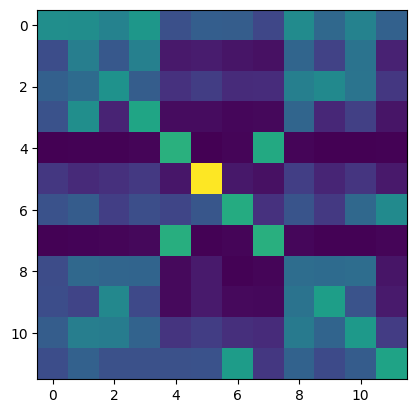

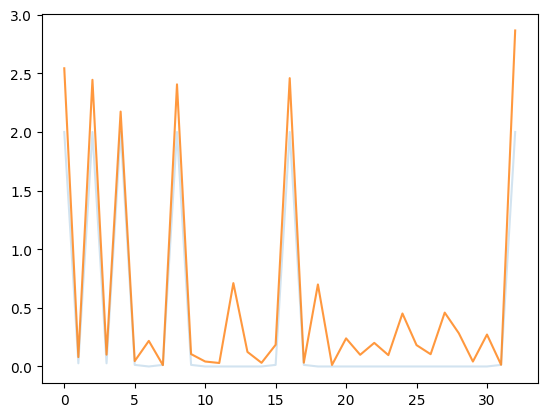

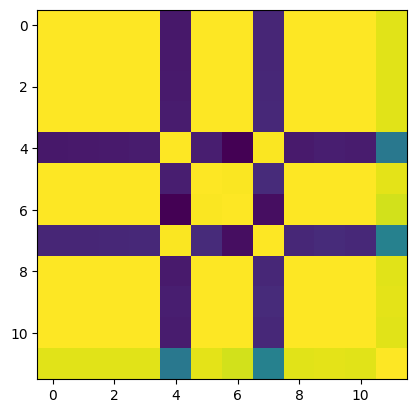

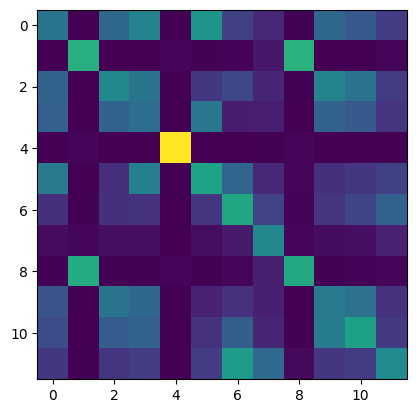

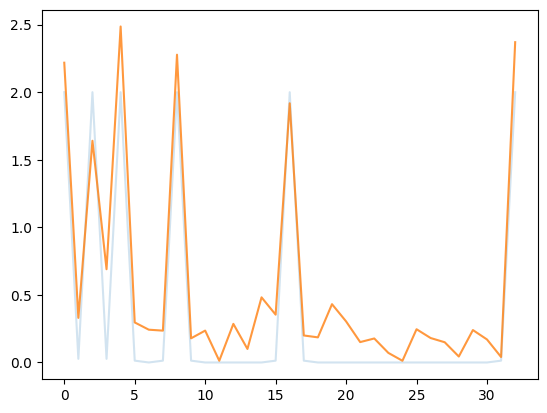

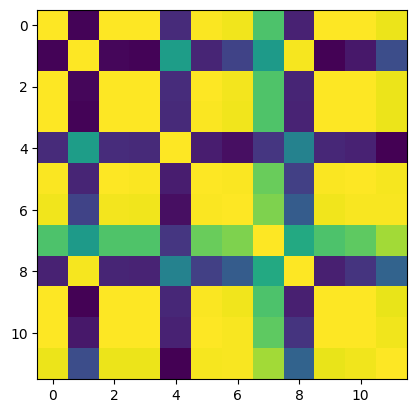

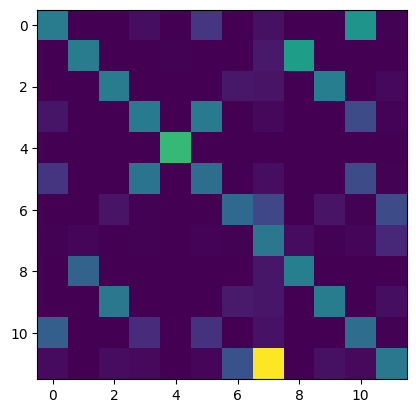

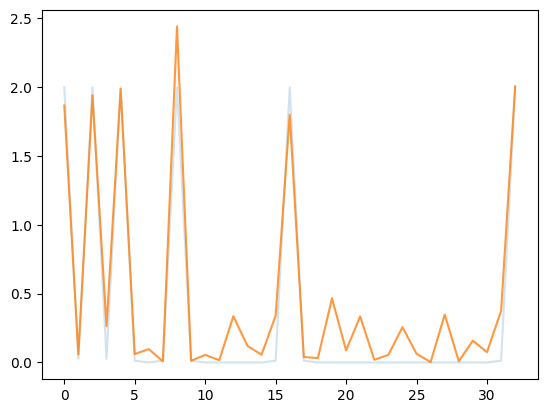

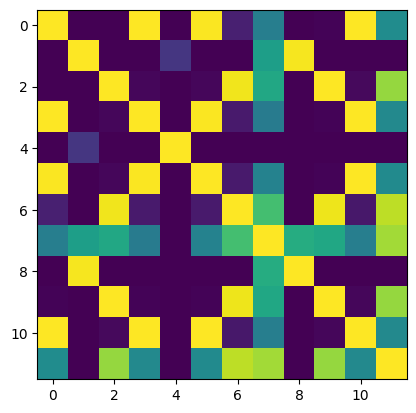

In [2]:
import sys
import yaml

sys.path.append("../")
import os
import torch
from misc import yaml_util as yu
import numpy as np

sys.path.append("../dataset")
sys.path.append("../module")
sys.path.append("../misc")

from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from misc import character_analysis as ca
from misc import loss_helper as lh
import pdb
import copy
from module import ft_decimation as ftd

import time


# datname = "OneDsignal_c8mimic_lowpow"

datname = "OneDsignal_c8mimic_lowpow"
modelname = "Plambda_OneD_RotMaskFeat3layer_thruDec_cosine"
trainname = "faster"


# datname = "OneDsignal_highlow8m"
# modelname = "Plambda_OneD_RotMaskFeat2layer_debug"
# trainname = "long_hor"


with open(f"""../cfg_data/{datname}.yaml""", "rb") as f:
    cfg_data = yaml.safe_load(f)

cfg_data["args"]["shift_label"] = True
mydata = yu.load_component(cfg_data)

expname = f"""{datname}_{modelname}_{trainname}"""

exppath = os.path.join("../dnftresult", expname)

mymodelpath = f"""{exppath}/model.pt"""
mymodel = torch.load(mymodelpath)


myloader = DataLoader(
    mydata,
    batch_size=32,
    shuffle=True,
    num_workers=2,
)


Ms = {} 
DMs = {} 
OMs = {}  
for k in range(mymodel.depth): 
    Ms[k]= []
    DMs[k] = None
    OMs[k] = None

for to_take_a_look in Ms.keys():
    
    if hasattr(mymodel, "nftlayers"):
        mynft = mymodel.nftlayers[to_take_a_look]
    else:
        mynft = mymodel


    shifts = []
    DMs[to_take_a_look] = mynft.PLambdaNet.dynamics_mask
    OMs[to_take_a_look] = mynft.PLambdaNet.own_mask


    
    if hasattr(mydata, "nfreq"):
        for k in range(20):
            evalseq, shift = next(iter(myloader))
            evalseq = evalseq[:, :2].to(mynft.encoder.device)
            predicted = mymodel(evalseq, n_rolls=1)
            shifts.append(shift)
            Ms[to_take_a_look].append(mynft.dynamics.M)
    
        shifts = torch.concatenate(shifts)
        Ms[to_take_a_look] = torch.concatenate(Ms[to_take_a_look]).detach()
    
        plt.figure()
    
        matrixMeanshape = torch.mean(torch.abs(Ms[to_take_a_look].detach()).to("cpu"), axis=0)
    
        plt.imshow(matrixMeanshape)
    
        myfreqs = np.array(mydata.freqsel)
        maxfreq = np.max(myfreqs)
    
        targfreq, prods0 = ca.inner_prod(
            Ms[to_take_a_look].to(shifts.device), shifts, maxfreq=maxfreq, bins=maxfreq + 1
        )
    
        plt.figure()
        deltas = ca.deltafxn(targfreq, mydata.freqsel) * 2
        plt.plot(
            targfreq,
            deltas,
            alpha=0.2,
            label="gt:" + str(np.where(deltas > 1.0)[0]),
        )
        targfreq, prods0 = ca.inner_prod(
            Ms[to_take_a_look].to(shifts.device), shifts, maxfreq=maxfreq, bins=maxfreq + 1
        )
        plt.plot(
            targfreq,
            prods0,
            label="pred0:" + str(np.where(prods0 > 1.0)[0]),
            alpha=0.8,
        )

        plt.figure()
        plt.imshow(DMs[to_take_a_look].detach().to('cpu')) 
    


In [6]:
checkidx = 0 
Plambdas = {} 
Plambdas[checkidx] = mymodel.nftlayers[checkidx].PLambdaNet

In [7]:
Plambdas[checkidx] 

RotFeatureMaskCosine(
  (rlnet): Sequential(
    (0): RotatingMaskLinear(
      (fc): MaskLinear(in_features=12, out_features=12, bias=False)
      (norm): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
    )
    (1): RotatingMaskLinear(
      (fc): MaskLinear(in_features=12, out_features=12, bias=False)
      (norm): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
    )
    (2): RotatingMaskLinear(
      (fc): MaskLinear(in_features=12, out_features=12, bias=False)
      (norm): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
    )
  )
)